In [ ]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym[atari]
!pip install pyvirtualdisplay
!conda install piglet
!pip install pystan
!conda install swig
!pip install box2d-py
!pip install gym[Box_2D]
#!pip install Box2D
!pip3 install pybullet --upgrade

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (477 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 784 kB of 

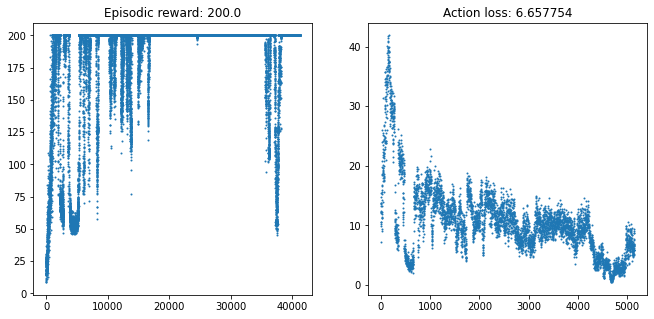

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 24 21:29:13 2020

@author: hongh
"""



import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.nn.functional as F 
import gym
import numpy as np
import pybullet_envs
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
import imageio
#get_ipython().run_line_magic('matplotlib', 'inline')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def plot(avg_rewards,action_losses,log_interval):
    '''        For monitoring the training process    '''
    clear_output(True)
    # plt.figure(figsize=(7,7)) 
    # plt.title(' reward: %s' % (np.mean(avg_rewards[-10:])))
    # plt.plot(avg_rewards)
    # plt.show()

    
    plt.figure(figsize=(11,5))
    plt.subplot(121)
    plt.title('Episodic reward: %s' % (np.mean(avg_rewards[-log_interval:])))
    plt.scatter(np.linspace(0,len(avg_rewards)-1,len(avg_rewards)),avg_rewards, s=1)

    plt.subplot(122)
    plt.title('Action loss: %s' % ( np.mean(action_losses[-log_interval:])))
    plt.scatter(np.linspace(0,len(action_losses)-1,len(action_losses)),action_losses, s=1)
    #plt.show()
    plt.savefig("Stats.png")

    plt.close("all")


class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.next_states = []
        self.logprobs = []
        self.rewards = []
        self.dones = []
        self.bootstrapes = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.dones[:]
        del self.bootstrapes[:]
        del self.next_states[:]
        
    def insert(self, state,action,next_state,reward,done,bootstrap):
        self.states.append(state)
        self.actions.append(action)
        self.next_states.append(next_state)
        self.rewards.append(reward)
        self.dones.append(done)
        self.bootstrapes.append(bootstrap)



    
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        '''To Do: Create an Actor network with 2 hidden layers.
            Each hidden layer with 64 neurons and using LeakyReLU(slope = 0.2) as activation. Output layer without activation
            The output of the network should be the number of discrete actions, 
            cooresponding to the probability of each action being chosen.
            Input argument: action_std is NOT USED in the discrete action space.
        '''
        self.actor =  nn.Sequential(
                    nn.Linear(state_dim, 64),
                    nn.LeakyReLU(negative_slope= 0.2),
                    nn.Linear(64, 64),
                    nn.LeakyReLU(negative_slope= 0.2),
                    nn.Linear(64, 64),
                    nn.LeakyReLU(negative_slope= 0.2),
                    nn.Linear(64, action_dim)
                )
        
    def forward(self): # THT: Don't we need this?
        raise NotImplementedError
    
    def act(self, state):
        ''' To Do:
        https://pytorch.org/docs/stable/distributions.html
        (1) first pass the state S to NN to get probailities for each, use F.softmax() to make sure the probability of each action is non-negative and the probability of all actions sum up to 1.
        (2) Create a torch.distribution.Categorical, which takes softmax version of probabilties 
        (3) sample an action according to the normal distribution in step 2, torch.distributions.sample()
        Input : state  (Tensor, [1, state_dim])
        Return: action (Tensor, [1])
        Note : .to(device) is required to make sure tensors are all on GPU or CPU.

        '''
        with torch.no_grad():
            action_probs = F.softmax(self.actor(state)) # To do:Perform softmax on the output to to get a probability on all actions. shape:[1,n_action]
        action_distribution = Categorical(action_probs) # To do:instantiate a Categorical distribution with action_probs
        action = action_distribution.sample() # To do:sample an action according to action_distribution , shape: [1]
        action = action.detach()
  
        return action

    def act_test(self, state):
        ''' To do: For testing phase, we would like to have deterministic action 
            by taking the action with the largest probability.
            Input : state  (Tensor, [1, state_dim])
            Return: action (Tensor, [1]) 
            Useful function: torch_Categorical_object.probs.argmax()
        '''
        with torch.no_grad():
            action_probs = F.softmax(self.actor(state)) # To do: Perform softmax on the output to get a probability on all actions . shape:[1,n_action]
        action_distribution = Categorical(action_probs) # To do: instantiate a Categorical distribution with action_probs
        action = torch.argmax(action_distribution.probs) # To do: Take the action index with the largest prob , shape: [1]
        return action.detach()
    
    def evaluate(self, state, action):   
        ''' To Do: Compute the action_logprobs and entropy in batch mode (for all samples in memory)       
            Useful function in pytorch : distribution.log_prob(), distribution.entropy()  
            see https://pytorch.org/docs/stable/distributions.html            
            Input : state (Tensor, [#rollout, state_dim]), action (Tensor, [#rollout, action_dim])
            Return: action_logprobs (1-D tensor)--> torch.size([rollout]) , dist_entropy (1-D tensor)--> torch.size([rollout])           
        '''  
        action_probs = F.softmax(self.actor(state))# as above
        action_distribution = Categorical(action_probs)# as above
        action_logprobs = action_distribution.log_prob(action)
        dist_entropy = action_distribution.entropy()
        return action_logprobs, dist_entropy



class REINFORCE:
    def __init__(self, state_dim, action_dim, lr, betas, gamma):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.actor = Actor(state_dim, action_dim).to(device)  
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=lr)
        self.MseLoss = nn.MSELoss()
        print(device)
    
    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor.act(state).cpu().data.numpy().flatten()
    
    def select_test_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor.act_test(state).cpu().data.numpy().flatten()
    
    
    def update(self, memory):
        '''This part is mostly similar to A2C-single-thread-continuous.py, where the difference is REINFORCE with Causality update'''
        # convert list to tensor
        states = torch.squeeze(torch.FloatTensor(np.stack(memory.states)).to(device), 1)
        actions = torch.squeeze(torch.FloatTensor(np.stack(memory.actions)).to(device), 1)  
        
        # --------------------compute value loss----------------
        # Compute the Monte-Carlo Returns as the update target for all V(S_t)               
        returns = [] 
      
        # To Do: initialize the td_target 0
        td_target = 0 # THT: Is this correct?
        # ----------Start computing returns------------

        for reward, done, bootstrap in zip(reversed(memory.rewards), reversed(memory.dones), reversed(memory.bootstrapes)):
            # Compute the returns according to causality.
            # returns = [td_target(S_0),td_target(S_1)...,td_target(S_T-1), # for the first episode
            #            td_target(S_0),td_target(S_1)...,td_target(S_T-1), # for the second episode
            #            ,....,
            #            td_target(S_0),td_target(S_1)...,td_target(S_T-1), # for the last episode]
            # returns is computed in reversed order!! First compute td_target(S_T-1) from the last episode,
            # then to  td_target(S_T-2) from the last epi,....td(S_0) of the last epi, td(S_T-1) of the LAST SECOND episode, td(S_T-2).... until the first
            if done==True and bootstrap==False: # 
                td_target = reward # THT: If the episode is done, the target should equal the reward, right? # To think
            td_target = td_target + self.gamma*reward #.... a recursive form to compute the td_target as the return, 'td_target' should appear on the right part of the equation.
            # To do: Insert the td_target into the first element of the list 'returns', while maintaning the existing elements in the list.
            returns = [td_target] + returns # THT: This prepends the td_target value to the front of the list

            
        returns = torch.FloatTensor(returns).to(device)

  
        #------------------ update action loss(REINFORCE)----------------    
        # Compute log-likelihood and entropy from the current distribution
        logprobs, dist_entropy = self.actor.evaluate(states, actions)
        action_loss = -logprobs * returns # THT: loss = -m.log_prob(action) * reward (example from https://pytorch.org/docs/stable/distributions.html and https://tims457.medium.com/policy-gradient-reinforcement-learning-in-pytorch-df1383ea0baf)# To Do :  
        # Encourage the agent to explore by maximizing the entropy
        action_loss =  1/len(action_loss) * torch.sum( action_loss + dist_entropy ) # THT: Add Entropy -> Higher Loss -> More Change when updating Network -> More Exploration # TO think : plus the entropy or minus the entropy   0.01 * dist_entropy.mean() 
        self.optimizer_actor.zero_grad()
        action_loss.backward()
        self.optimizer_actor.step()       
        # print('value loss: {}, action loss: {}'.format(value_loss, action_loss))  
        return action_loss.cpu().data.numpy().flatten()
        
        
def main():
    # Although you don't need to modify the program in the main(), it is definitely necessary to read into that.
    # 

    ############## Hyperparameters ##############
    env_name = 'CartPoleBulletEnv-v1'
    # creating environment
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    render = False
    solved_reward = np.inf         # stop training if avg_reward > solved_reward
    log_interval = 5         # print avg reward in the interval
    max_iterations = 10000        # max training episodes
    max_timesteps = env._max_episode_steps        # max timesteps in one episode
    print(env._max_episode_steps)
    update_every_N_complete_episode = 8      # IMPORTANT:  update policy every _N_complete_episode. For REINFORCE, this should be 1. But for a stable performance, it is recommeded to set as 8.  
    gamma = 0.99                # discount factor
    lr = 0.001                 # parameters for Adam optimizer
    betas = (0.9, 0.999)
    # Note: Boostraping mode affects (1) How the MC-returns are computed in REINFORCE.update() 
    # (2) If enabled, only in case of the pseudo termination (reaching maximal episode instead of terminal states), done is set as False, Bootstrap flag is set true.
    # For REINFORCE, we set bootstrapping mode to be False, as bootstrapping requires a critic approximating the V(S), but REINFORCE by nature doesn't have a critic part.
    allow_bootstrapping_mode = False   
    random_seed = None
    #############################################
    

    
    if random_seed:
        print("Random Seed: {}".format(random_seed))
        torch.manual_seed(random_seed)
        env.seed(random_seed)
        np.random.seed(random_seed)
    
    memory = Memory()
    reinforce = REINFORCE(state_dim, action_dim, lr, betas, gamma)
    print(lr,betas)
    
    # logging variables
    episodic_reward = 0
    avg_length = 0
    time_step = 0 # Count of episodic length within each update iteration, of different definition from previous versions
    done_count_in_an_itr = 0 # For statistical purpose: Counts for (#True termination for an episode + #Maximal episodic length reached)
    avg_rewards, action_losses = [] , []

    # training loop, one iteration means collecting (N = 8) complete episodes and then do the update for actor.
    for i_iter in range(1, max_iterations+1):
        state = env.reset()           
        episodic_reward, avg_reward = 0, 0
        done_count_in_an_itr = 0
        time_step = 0
        
            # -----------------Test----------------
        if i_iter % 10 == 0:                  
            test_reward = 0
            env_test = gym.make(env_name)
            test_state = env_test.reset()
            test_done = False
            images = []
            print('-----------starting test-----------')
            for i in range(max_timesteps):
                action = reinforce.select_test_action(test_state)
                env_test.render()
                test_state, reward, test_done, _ = env_test.step(action[0])
                test_reward += reward
                if test_done == True:
                    break
            print('Test reward : {}'.format(test_reward))  
        
        while done_count_in_an_itr < update_every_N_complete_episode:
            time_step +=1
            # Running policy_old:
            action = reinforce.select_action(state)
            next_state, reward, done, _ = env.step(action[0])

            # Saving reward and dones: 
            if (time_step == env._max_episode_steps) and (done == True):
                if allow_bootstrapping_mode:
                    # Enable bootstrapping for the last experience reaching maximal episodic length
                    memory.insert(state, action, next_state, reward, False, True)
                else:
                    # Disable bootstrapping
                    memory.insert(state, action, next_state, reward, done, False)
                time_step = 0
            else:
                memory.insert(state, action, next_state, reward, done, False)
            
            # update if collecting enough experience
            if (done_count_in_an_itr == update_every_N_complete_episode - 1) and done:
                value_loss = reinforce.update(memory)
                memory.clear_memory()
                state = env.reset()
                action_losses.append(value_loss[0])
                    
            episodic_reward += reward
            state = next_state 
            
            if done:  
                state = env.reset()
                done_count_in_an_itr += 1
                avg_reward += (1/done_count_in_an_itr) * (episodic_reward-avg_reward)
                episodic_reward = 0
                time_step = 0
                avg_rewards.append(avg_reward)
            

        # stop training if avg_reward > solved_reward
        if avg_reward >= solved_reward:
            print("########## Solved! ##########")
            #-------- You could save the network here------------
            env_test = gym.make(env_name)
            test_state = env_test.reset()
            images = []
            for i in range(max_timesteps):
                action = reinforce.select_test_action(test_state)
                img = env_test.render(mode="rgb_array")
                test_state, reward, test_done, _ = env_test.step(action[0])
                images.append(img)
                if test_done == True:
                    break

            imageio.mimsave('anim.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

            plot(avg_rewards, action_losses, log_interval)
            break
        
            
        # logging
        if i_iter % log_interval == 0:
            print('Iteration {} \t Avg reward: {} \t Loss: {}'.format(i_iter, avg_reward, action_losses[-1]))
            plot(avg_rewards, action_losses, log_interval)
            
if __name__ == '__main__':
    main()